# Student alcohol consumption
Marco Spanò (s1045892) - Peter Horvath (s1042834)

### Problem:

Alcohol has a bad influence on human life. Despite this, alcoholic drinks are nowadays really
common, especially in teenagers’ life that are the ones who suffer the most from the
consequences of it (the effects alcohol has on the brain and everyday’s life).
The dataset we found contains records of students in secondary school that attended math
and portuguese language courses with 33 attributes regarding personal info, alcohol
consumption, grades and more.
Starting from this dataset we are going to make inferences such as the level of alcohol
consumption of a student (based on the other columns) or predicting the grades he/she will
get. Furthermore, we can also explore some characteristics of the dataset, like inspecting
how alcohol influences the grades of a student.
Finally we can try to compare these results with other’s taken from other similar dataset
(students from different countries or older/younger) and see if there is correlation from them.
Dataset: https://www.kaggle.com/uciml/student-alcohol-consumption#student-mat.csv

### Our solution:

Our first aim is to start applying a decision tree classifier (and later on also a random forest)
on the dataset since it is easily understandable and as well as having a good classifier we
can also see which are the variables that most affect the final result.
Secondly we will apply a naive bayes classifier to compare the results we get from the
decision tree to it. Also with the naive classifier we can try to inspect which attributes
contribute the most to predict the outcome.
Eventually we can try to apply a small neural network on the dataset and see if it we can
achieve a better accuracy, even if the dataset is not so big and the probability of it are low.

### Literature:

Paper from the researchers who shared the dataset:
https://bradzzz.gitbooks.io/ga-seattle-dsi/dsi/dsi_05_classification_databases/2.1-lesson/ass
ets/datasets/STUDENT%20ALCOHOL%20CONSUMPTION.pdf
A study on alcohol consumption of undergraduate students in the UK in 2000-2001:
https://bmcpublichealth.biomedcentral.com/articles/10.1186/1471-2458-8-163
A similar study also in UK during 2008-2009:
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3843305/

In [26]:
import pandas as pd
import numpy as np
import category_encoders as ce
%matplotlib inline

#reading the two csv files and merging them with 'append'
data_mat = pd.read_csv('student-mat.csv')
data_por = pd.read_csv('student-por.csv')
merged = data_mat.append(data_por)

column_names = merged.columns
classNames = merged.G3.unique()
classNames = np.sort(classNames)
print(classNames)


#we have to use certain columns for removing duplicates (not all of the columns), the column names are given in the .R file
column_names_for_subsetting = ["school","sex","age","address","famsize","Pstatus","Medu","Fedu","Mjob","Fjob","reason","nursery","internet"]
merged = merged.drop_duplicates(subset = column_names_for_subsetting).values

print(data_mat.shape)
print(data_por.shape)
print(merged)

[ 0  1  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
(395, 33)
(649, 33)
[['GP' 'F' 18 ... 5 6 6]
 ['GP' 'F' 17 ... 5 5 6]
 ['GP' 'F' 15 ... 7 8 10]
 ...
 ['MS' 'F' 18 ... 16 15 15]
 ['MS' 'F' 19 ... 7 8 9]
 ['MS' 'F' 17 ... 6 9 11]]


In [27]:
# creating a categorical encoder with the indices list
# the encoder will encode only those columns which are in the indices
indices = [0,1,3,4,5,8,9,10,11,15,16,17,18,19,20,21,22]
encoder = ce.ordinal.OrdinalEncoder(cols = indices)

#encoding the selected columns
#the encoder returns a pandas dataframe so we have to use the 'values' again to get the values in a numpy array
merged = encoder.fit_transform(merged)
merged = merged.values
print(merged)




[[ 1  1 18 ...  5  6  6]
 [ 1  1 17 ...  5  5  6]
 [ 1  1 15 ...  7  8 10]
 ...
 [ 2  1 18 ... 16 15 15]
 [ 2  1 19 ...  7  8  9]
 [ 2  1 17 ...  6  9 11]]


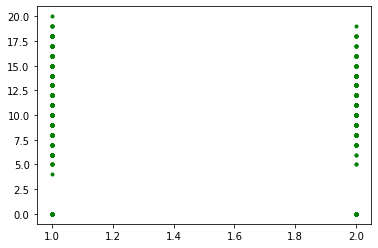

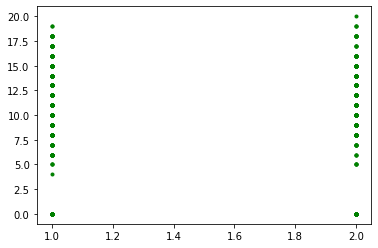

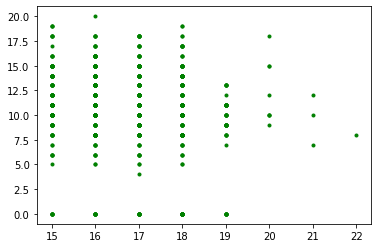

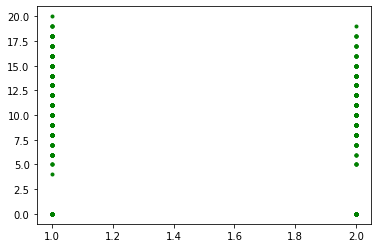

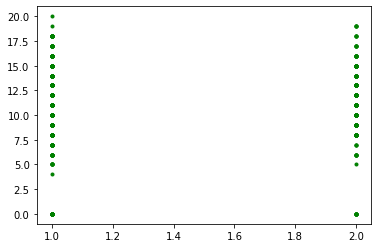

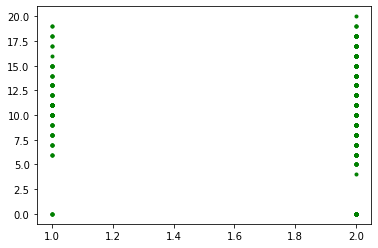

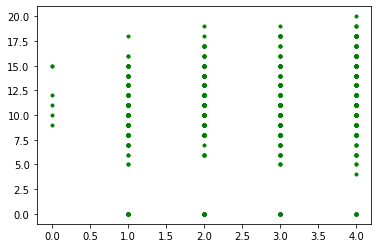

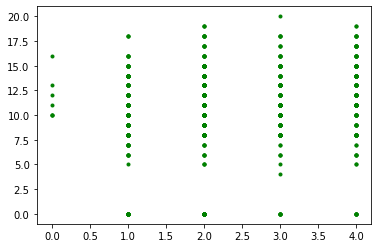

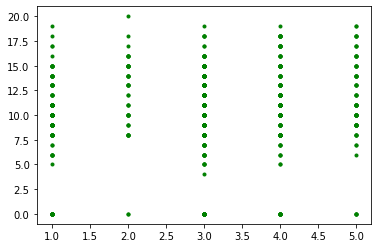

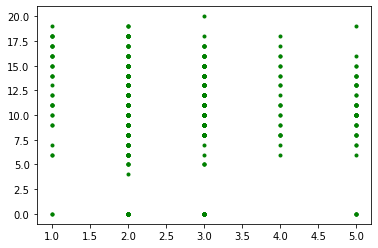

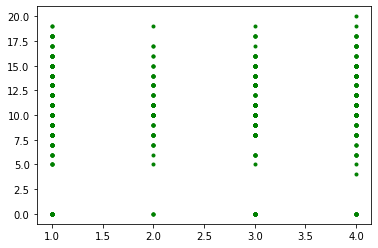

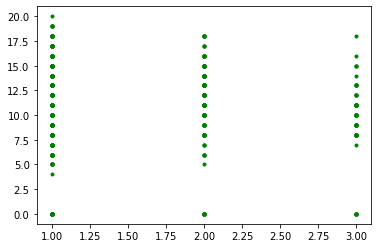

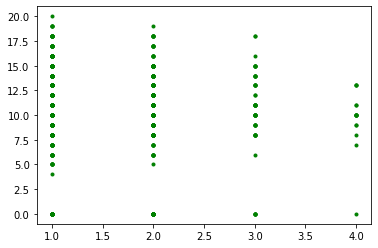

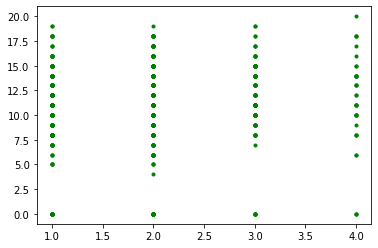

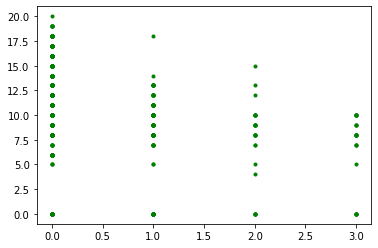

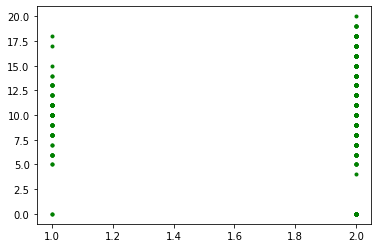

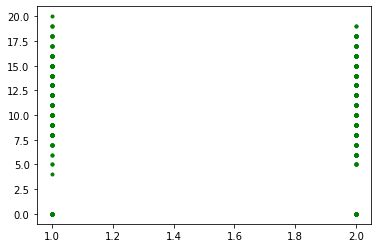

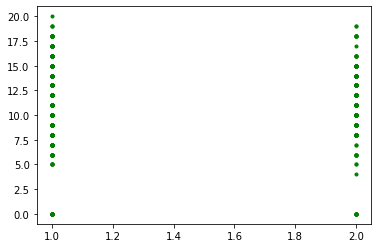

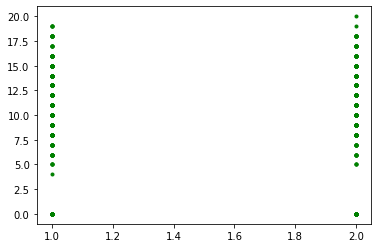

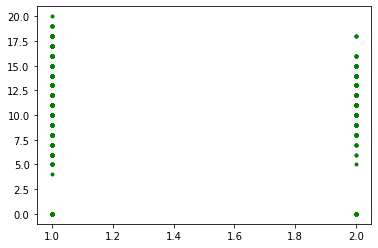

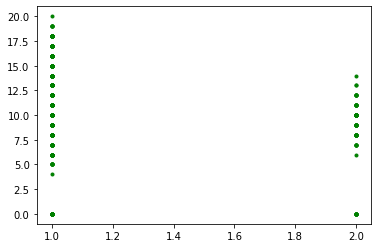

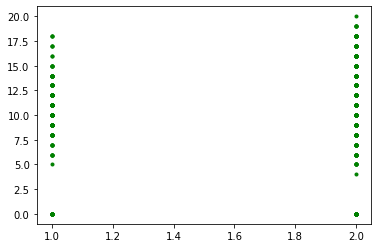

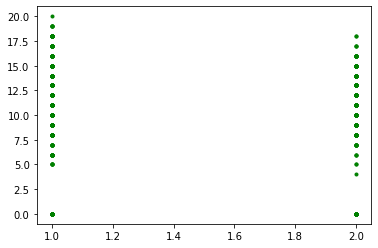

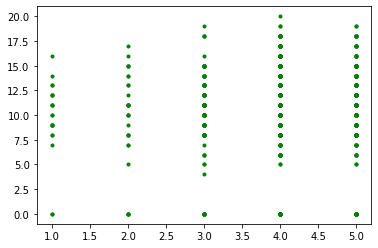

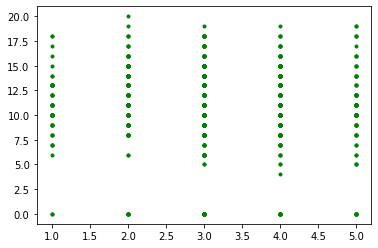

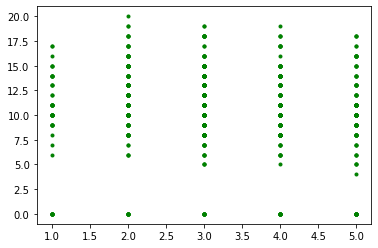

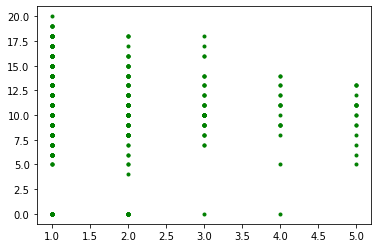

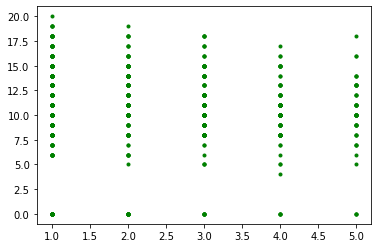

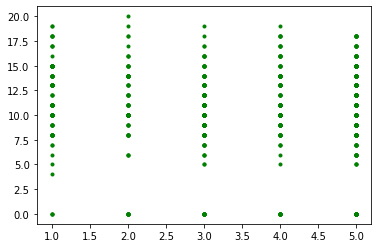

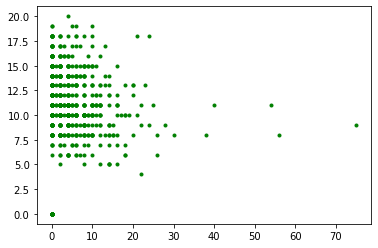

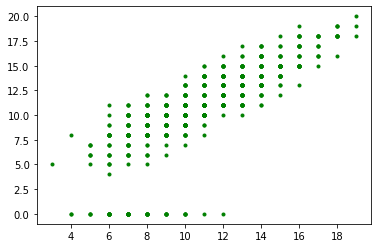

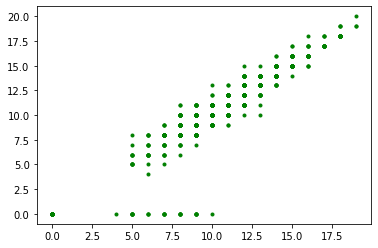

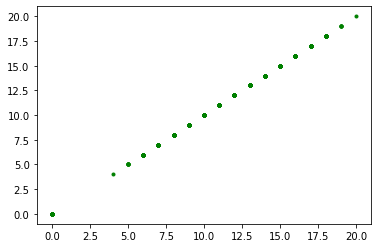

<Figure size 432x288 with 0 Axes>

In [28]:
import matplotlib.pyplot as plt
import numpy as np

for i in range(0,33):
    #fig, pc = plt.subplots(1,2,figsize=(10,10))
    #for j in range(1,2):
    plt.plot(merged[:, i], merged[:, 32], 'g.')
    
    plt.show()
#         pc[0][j].set_title(f'PC {i+1} over PC {j+1}')
#         pc[0][j].set_xlabel(f'PC {i+1}')
#         pc[0][j].set_ylabel(f'PC {j+1}')


plt.tight_layout()
plt.show()

# Preprocessing

In [29]:
#deleting possible outliers, the one with grade 0, 1 or 5
merged = merged[merged[:,32] > 0, :]
print(merged)

[[ 1  1 18 ...  5  6  6]
 [ 1  1 17 ...  5  5  6]
 [ 1  1 15 ...  7  8 10]
 ...
 [ 2  1 18 ... 16 15 15]
 [ 2  1 19 ...  7  8  9]
 [ 2  1 17 ...  6  9 11]]


In [30]:
merged_std = (merged - np.mean(merged, axis=0)) / np.std(merged, axis=0)
print(merged_std)

[[-0.72870939 -0.84210526  0.96238353 ... -1.98058448 -1.74256804
  -1.82898916]
 [-0.72870939 -0.84210526  0.17066268 ... -1.98058448 -2.07803278
  -1.82898916]
 [-0.72870939 -0.84210526 -1.41277902 ... -1.31716394 -1.07163857
  -0.50057679]
 ...
 [ 1.37228917 -0.84210526  0.96238353 ...  1.66822846  1.27661459
   1.15993868]
 [ 1.37228917 -0.84210526  1.75410438 ... -1.31716394 -1.07163857
  -0.83267988]
 [ 1.37228917 -0.84210526  0.17066268 ... -1.64887421 -0.73617383
  -0.16847369]]


In [31]:
from sklearn.preprocessing import normalize

merged_norm = normalize(merged, axis=0)

# Dividing in training and test

In [32]:
import sklearn.model_selection as skl

#shows how much data you want to put in the testing dataset, the rest goes to the training one
holdout = 0.3

#use the same seed for all the depths
random_seed = 0

X = merged[:, :30]
y = merged[:, 32]

print(X.shape, y.shape)

X_train, X_test, y_train, y_test = skl.train_test_split(X, y, test_size=holdout, random_state=random_seed)

(617, 30) (617,)


# PCA 

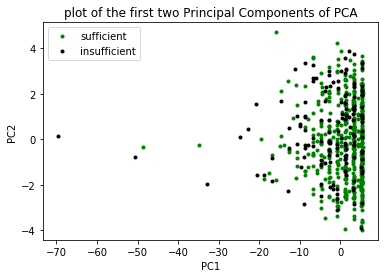

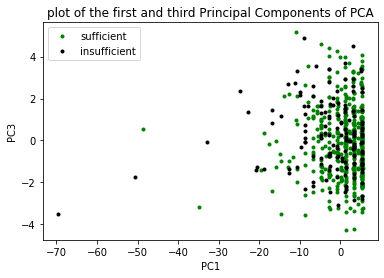

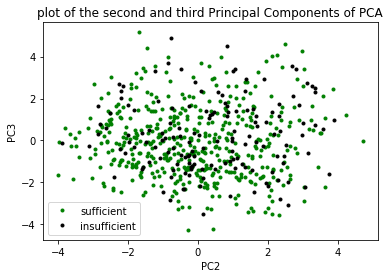

In [34]:
X = merged[:, :30]
#target = merged[:, 32]

target = merged[:,32] >= 10
#print(merged[:,32], target)

mean = np.mean(X, axis=0)

Y = X - mean

U, S, VT = np.linalg.svd(Y)


V = VT.T
#print(V.shape)
Z = np.dot(Y, V)

plt.plot(Z[target==True, 0], Z[target==True, 1],'g.', label="sufficient")
plt.plot(Z[target==False, 0], Z[target==False, 1],'k.', label="insufficient")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('plot of the first two Principal Components of PCA')
plt.legend()
plt.show()

plt.plot(Z[target==True, 0], Z[target==True, 2],'g.', label="sufficient")
plt.plot(Z[target==False, 0], Z[target==False, 2],'k.', label="insufficient")
plt.xlabel('PC1')
plt.ylabel('PC3')
plt.title('plot of the first and third Principal Components of PCA')
plt.legend()
plt.show()

plt.plot(Z[target==True, 1], Z[target==True, 2],'g.', label="sufficient")
plt.plot(Z[target==False, 1], Z[target==False, 2],'k.', label="insufficient")
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.title('plot of the second and third Principal Components of PCA')
plt.legend()
plt.show()

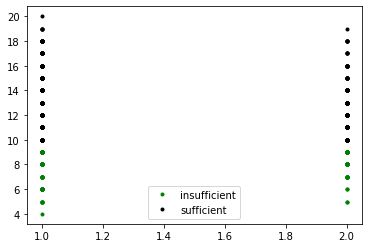

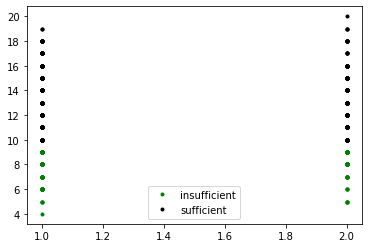

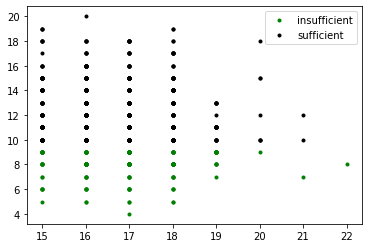

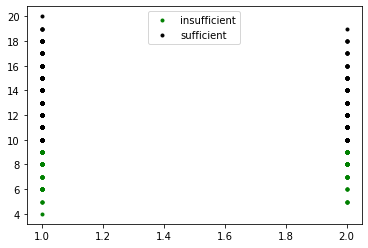

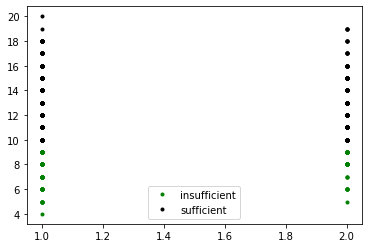

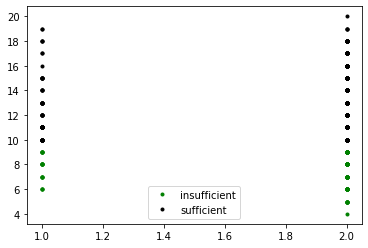

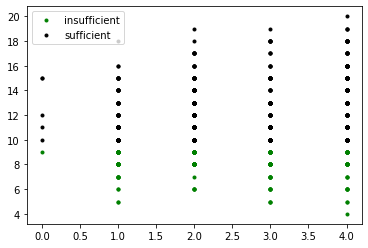

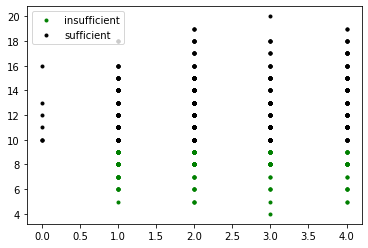

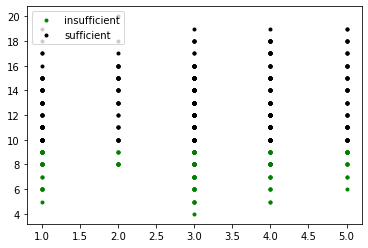

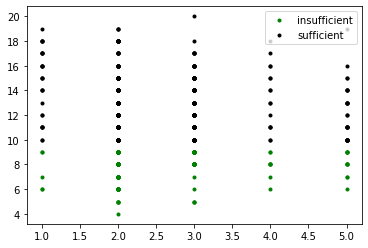

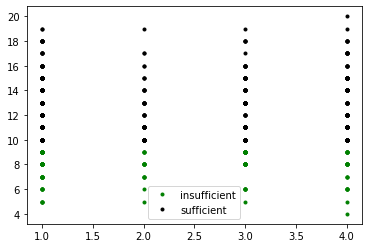

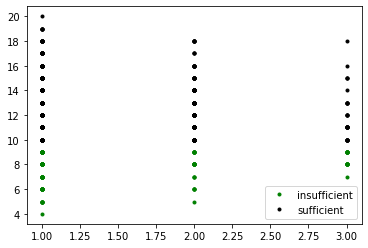

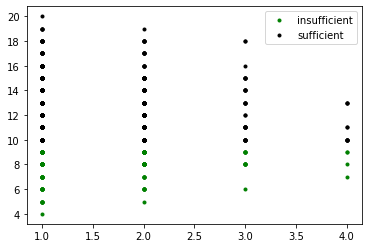

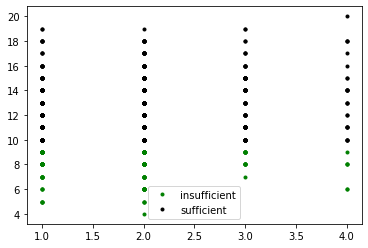

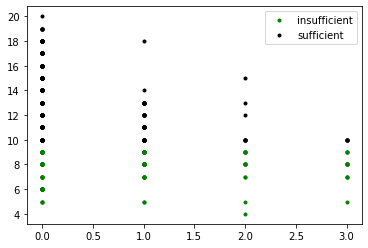

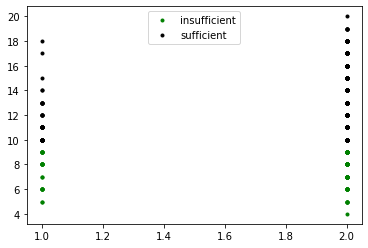

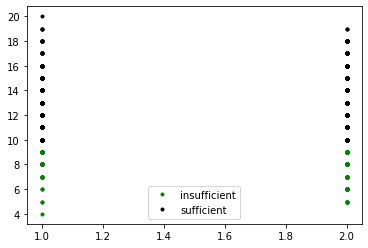

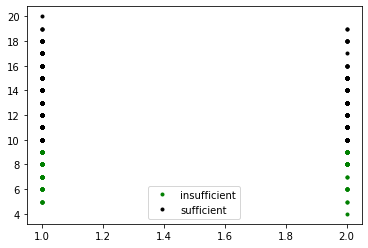

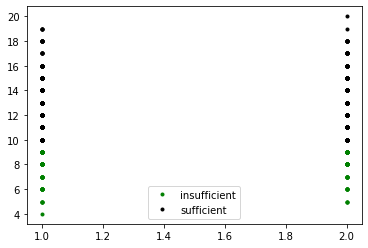

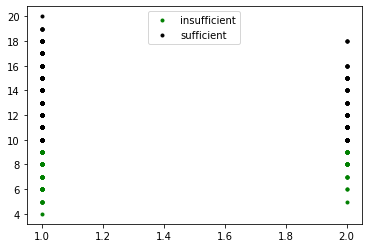

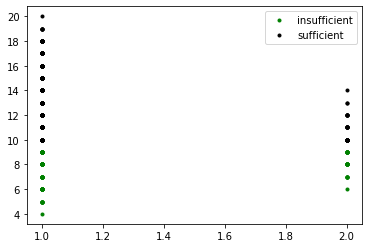

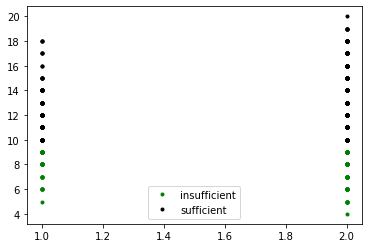

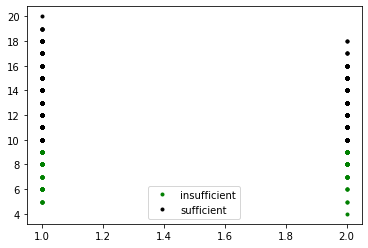

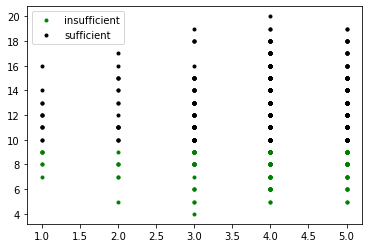

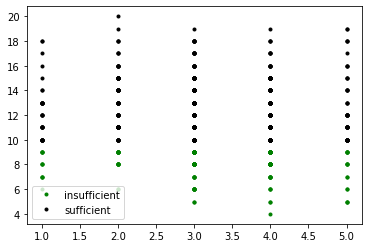

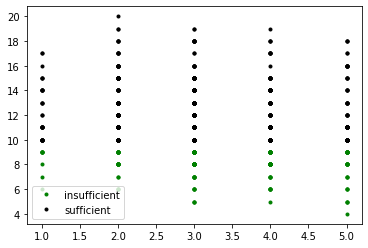

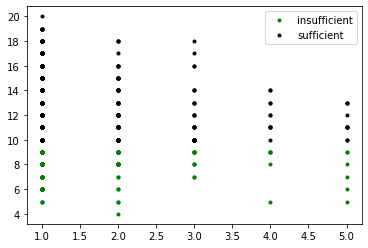

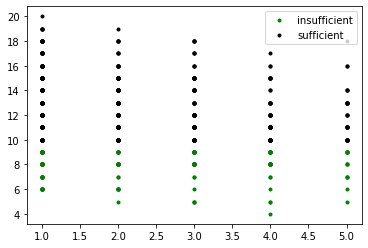

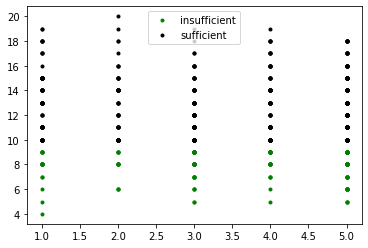

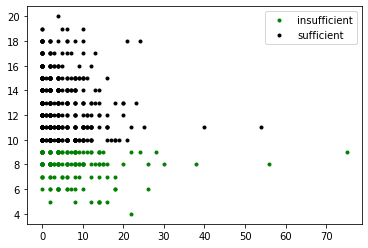

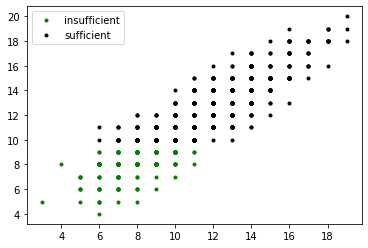

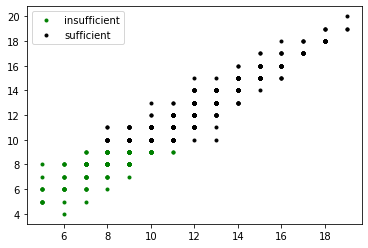

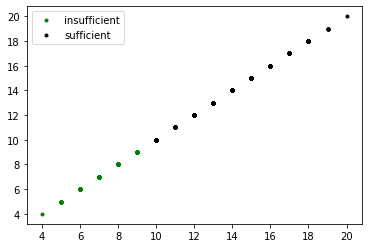

<Figure size 432x288 with 0 Axes>

In [25]:
for i in range(0,33):
    #fig, pc = plt.subplots(1,2,figsize=(10,10))
    #for j in range(1,2):
    plt.plot(merged[target==False, i], merged[target==False, 32], 'g.', label="insufficient")
    plt.plot(merged[target==True, i], merged[target==True, 32], 'k.', label="sufficient")
    plt.legend()
    
    plt.show()
#         pc[0][j].set_title(f'PC {i+1} over PC {j+1}')
#         pc[0][j].set_xlabel(f'PC {i+1}')
#         pc[0][j].set_ylabel(f'PC {j+1}')


plt.tight_layout()
plt.show()